In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings('ignore', category=UserWarning, message="Line Search failed")

In [130]:
#load data and preprocess
file_path = "/content/drive/MyDrive/ML_HW_4_5/labelled data.csv"
data = pd.read_csv(file_path,index_col=0).fillna(0)
print(data.head())
print(data.isnull().sum())

      Name        FC     logFC    logCPM   P-Value       FDR  SCLC  NSCLC
0  KRT16P5 -1.474275 -0.560006 -2.065784  0.423250  0.645529   0.0    0.0
1  KRT16P3 -1.158475 -0.212227  0.698547  0.598622  0.779482   0.0    0.0
2  KRT16P2  1.785481  0.836313  3.744968  0.060200  0.211667   0.0    0.0
3  KRT16P6 -2.534136 -1.341494  0.404997  0.023716  0.123727   0.0    0.0
4    CRHBP  1.441891  0.527962 -0.015277  0.034942  0.153404   0.0    0.0
Name       0
FC         0
logFC      0
logCPM     0
P-Value    0
FDR        0
SCLC       0
NSCLC      0
dtype: int64


EDA

In [131]:
print(data.shape)
print()
print(data.describe)
print()
print(data.info)
print()
print(data.duplicated())
print()
print(data.dtypes)

(19778, 8)

<bound method NDFrame.describe of                Name        FC     logFC    logCPM   P-Value       FDR  SCLC  \
0           KRT16P5 -1.474275 -0.560006 -2.065784  0.423250  0.645529   0.0   
1           KRT16P3 -1.158475 -0.212227  0.698547  0.598622  0.779482   0.0   
2           KRT16P2  1.785481  0.836313  3.744968  0.060200  0.211667   0.0   
3           KRT16P6 -2.534136 -1.341494  0.404997  0.023716  0.123727   0.0   
4             CRHBP  1.441891  0.527962 -0.015277  0.034942  0.153404   0.0   
...             ...       ...       ...       ...       ...       ...   ...   
19773  LOC105369958  2.196994  1.135531  1.382694  0.003199  0.040235   0.0   
19774         ABCC2  3.461301  1.791314  5.336636  0.000671  0.015864   0.0   
19775         TRAV6  3.849574  1.944699 -0.401490  0.000016  0.001372   0.0   
19776  LOC105369904  2.226049  1.154485 -1.006838  0.002616  0.035713   0.0   
19777  LOC101928636  2.279563  1.188757  0.151617  0.000219  0.007721   0.0   

     

In [132]:
print(data.columns[data.isna().any()])
print()

Index([], dtype='object')



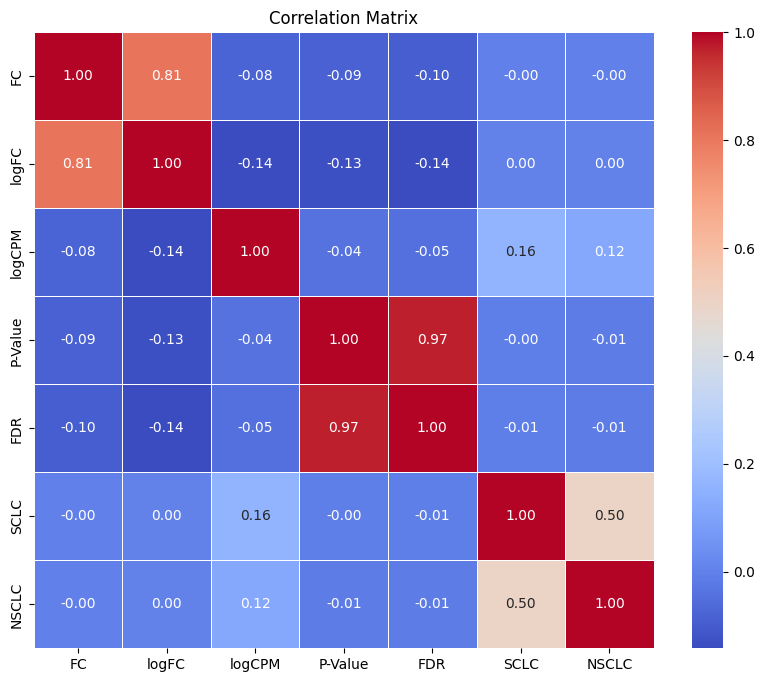

In [134]:
correlation_matrix = data.corr()
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [135]:
#feature selection
features = data[['FC', 'logFC', 'P-Value']]
targets = {'NSCLC': data['NSCLC'], 'SCLC': data['SCLC']}

In [136]:
nsclc = data['NSCLC']
sclc = data['SCLC']

In [137]:
nm = NearMiss()
print('SCLC Original Shape:', Counter(sclc))
features_nm_sclc, nm_sclc = nm.fit_resample(features, sclc)
print('SCLC Resample Shape:', Counter(nm_sclc))
print('NSCLC Original Shape:', Counter(nsclc))
features_nm_nsclc, nm_nsclc = nm.fit_resample(features, nsclc)
print('NSCLC Resample Shape:', Counter(nm_nsclc))

SCLC Original Shape: Counter({0.0: 18857, 1.0: 921})
SCLC Resample Shape: Counter({0.0: 921, 1.0: 921})
NSCLC Original Shape: Counter({0.0: 19087, 1.0: 691})
NSCLC Resample Shape: Counter({0.0: 691, 1.0: 691})


In [138]:
features_sclc = features_nm_sclc
features_nsclc = features_nm_nsclc
sclc = nm_sclc
nsclc = nm_nsclc

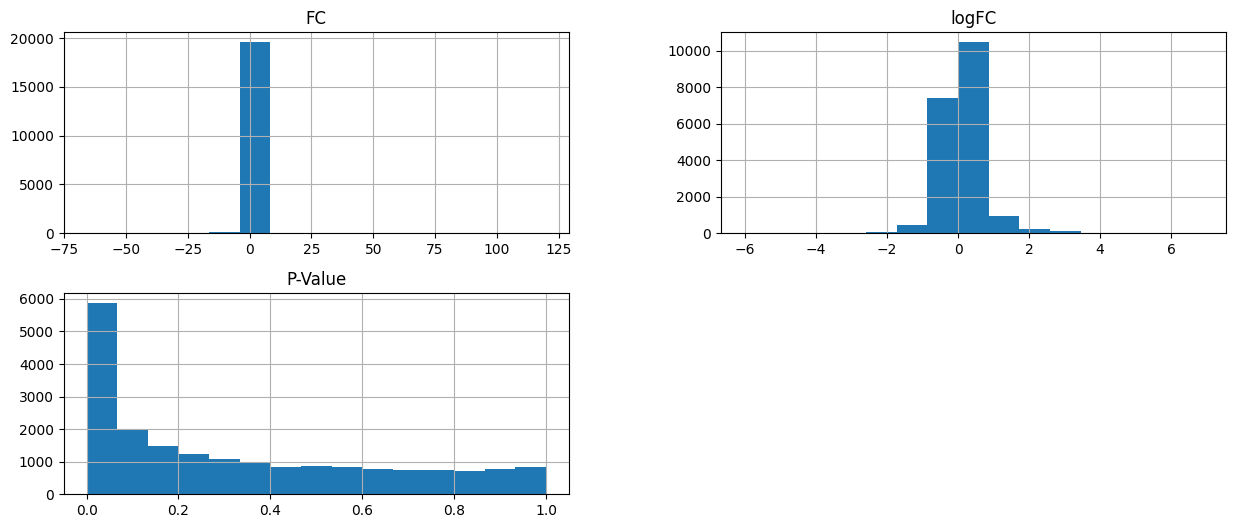

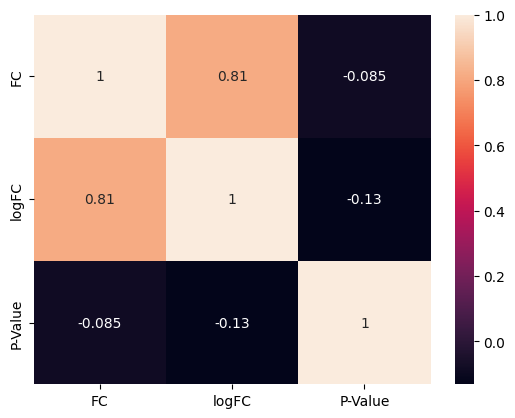

In [139]:
#EDA
#histograms and correlation matrix
features.hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.show()
sns.heatmap(features.corr(), annot=True)
plt.show()

In [140]:
def train_test_and_standardize(features, target, test_size=0.2, random_state=42):
    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test

xtrain_sclc, xtest_sclc, ytrain_sclc, ytest_sclc = train_test_and_standardize(features_sclc, sclc)
xtrain_nsclc, xtest_nsclc, ytrain_nsclc, ytest_nsclc = train_test_and_standardize(features_nsclc, nsclc)

In [141]:
# AdaBoost Pipeline
base_estimator = DecisionTreeClassifier(class_weight='balanced')  # base estimator
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier(base_estimator=base_estimator))
])

# Parameter Grid for AdaBoost
param_grid_adaboost = {
    'adaboost__n_estimators': [50, 100, 200],
    'adaboost__learning_rate': [0.05, 0.1, 0.5, 1.0],
    'adaboost__algorithm': ['SAMME', 'SAMME.R'],
    'adaboost__random_state': [None, 42, 100],
    'adaboost__base_estimator__max_depth': [1, 2, 3, 4],
    'adaboost__base_estimator__min_samples_split': [2, 5, 10],
    'adaboost__base_estimator__min_samples_leaf': [1, 2, 4, 6],
    'adaboost__base_estimator__criterion': ['gini', 'entropy'],
    'adaboost__base_estimator__max_features': [None, 'sqrt', 'log2'],
    'adaboost__base_estimator__splitter': ['best', 'random']
}

In [142]:
def evaluate_adaboost(x_train, y_train, x_test, y_test, param_grid):
    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, scoring='f1',n_iter= 1000, cv=10, verbose=1, n_jobs=-1)
    grid_search.fit(x_train, y_train)  # Fit on training data
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_adaboost = pipeline.set_params(**best_params)
    best_adaboost.fit(x_train, y_train)  # Refit on training data
    y_test_pred = best_adaboost.predict(x_test)  # Predict on test data
    report = classification_report(y_test, y_test_pred)
    return best_params, best_score, report

In [143]:
best_params_nsclc, best_score_nsclc, report_nsclc = evaluate_adaboost(xtrain_nsclc, ytrain_nsclc, xtest_nsclc, ytest_nsclc, param_grid_adaboost)
print("Best Parameters for NSCLC:", best_params_nsclc)
print("Best F1 Score for NSCLC:", best_score_nsclc)
print("Classification Report for NSCLC (Test Data):\n", report_nsclc)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Best Parameters for NSCLC: {'adaboost__random_state': 100, 'adaboost__n_estimators': 50, 'adaboost__learning_rate': 0.1, 'adaboost__base_estimator__splitter': 'best', 'adaboost__base_estimator__min_samples_split': 2, 'adaboost__base_estimator__min_samples_leaf': 1, 'adaboost__base_estimator__max_features': 'sqrt', 'adaboost__base_estimator__max_depth': 3, 'adaboost__base_estimator__criterion': 'gini', 'adaboost__algorithm': 'SAMME'}
Best F1 Score for NSCLC: 0.8498770054338733
Classification Report for NSCLC (Test Data):
               precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       142
         1.0       0.81      0.81      0.81       135

    accuracy                           0.82       277
   macro avg       0.82      0.82      0.82       277
weighted avg       0.82      0.82      0.82       277



In [127]:
best_params_nsclc, best_score_nsclc, report_nsclc = evaluate_adaboost(xtrain_sclc, ytrain_sclc, xtest_sclc, ytest_sclc, param_grid_adaboost)
print("Best Parameters for NSCLC:", best_params_nsclc)
print("Best F1 Score for NSCLC:", best_score_nsclc)
print("Classification Report for NSCLC (Test Data):\n", report_nsclc)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best Parameters for NSCLC: {'adaboost__random_state': 100, 'adaboost__n_estimators': 100, 'adaboost__learning_rate': 0.05, 'adaboost__base_estimator__splitter': 'best', 'adaboost__base_estimator__min_samples_split': 10, 'adaboost__base_estimator__min_samples_leaf': 2, 'adaboost__base_estimator__max_features': 'sqrt', 'adaboost__base_estimator__max_depth': 3, 'adaboost__base_estimator__criterion': 'entropy', 'adaboost__algorithm': 'SAMME.R'}
Best F1 Score for NSCLC: 0.8115145193902691
Classification Report for NSCLC (Test Data):
               precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       188
         1.0       0.86      0.76      0.80       181

    accuracy                           0.82       369
   macro avg       0.82      0.82      0.82       369
weighted avg       0.82      0.82      0.82       369

